In [1]:
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch

In [4]:
import torch.nn.functional as F


In [64]:
import torch.nn as nn

In [5]:
df = pd.read_excel("data/SEF_NOF_SHF_Orginal.xlsx")

In [6]:
df_ser = df[[k for k in df.keys() if "series" in k.lower()]]
df_shu = df[[k for k in df.keys() if "shunt" in k.lower()]]
df_no = df[[k for k in df.keys() if "no" in k.lower()]]

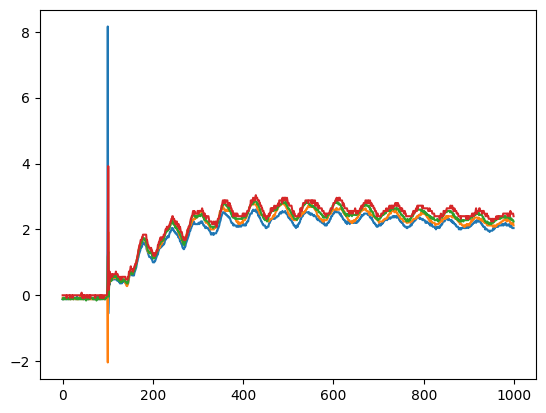

In [7]:
plt.plot(df_no);

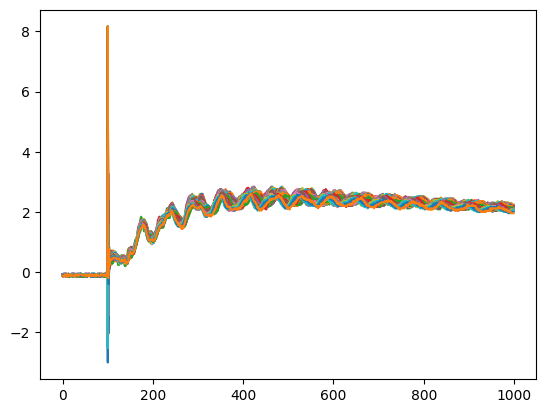

In [8]:
plt.plot(df_ser);

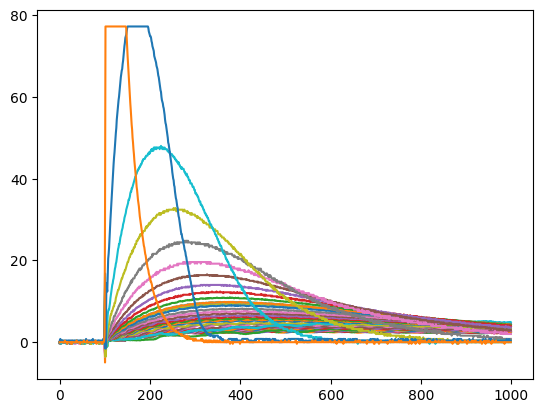

In [9]:
plt.plot(df_shu);

In [10]:
T = 1000

In [452]:
torch.set_default_dtype(torch.float64)
alphas = 1. - torch.linspace(0.001, 0.2, T)
alphas_cumprod = torch.cumprod(alphas, axis=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

In [462]:

class DenoiseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, padding=1, bias=False)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=3, padding=1, bias=False)
        self.fc1 = nn.Linear(2200, 200)
        self.fc2 = nn.Linear(880+200+20, 880)

        self.tnet = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 20),
            nn.Tanh()
        )

    def forward(self, x, t):
        xt = x.squeeze()
        t2 = self.tnet(sqrt_alphas_cumprod[t])
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = x.view(-1, 2200)
        # x = torch.cat((x0, x.squeeze()))
        x = F.tanh(self.fc1(x))
        # print(x0.size(), x.size())
        # print(x.shape, xt.shape)
        x = torch.cat((xt, x.squeeze(), t2))
        x = self.fc2(x)
        return (xt - sqrt_alphas_cumprod[t] * x)/sqrt_one_minus_alphas_cumprod[t]
        # return self.net(torch.cat((x, t)))



In [463]:
model = DenoiseModel()   

In [464]:
import random

In [465]:
test_sigs = []
es = []
xt_test = torch.tensor(df_ser[random.choice(df_ser.keys())][120:].to_numpy())
for t in range(T):
    e = torch.randn_like(xt_test)
    es.append(e)
    test_sigs.append(sqrt_alphas_cumprod[t] * xt_test + sqrt_one_minus_alphas_cumprod[t] * e)

In [487]:
optimizer = torch.optim.Adam(model.parameters())
from collections import deque
import statistics
n_epochs = 50
hist = deque(maxlen=100)
hist_meds = []
for step in range(n_epochs):
    optimizer.zero_grad()
    for _, xt in df_ser.transpose().iterrows(): 
        xt = torch.tensor(xt[120:].to_numpy())
        ts = [*range(30)]
        random.shuffle(ts)
        for t in ts:
            t = torch.tensor([t]) #torch.randint(0, 30, (1,))  # Pick random time step
            e = torch.randn_like(xt)
            xt = sqrt_alphas_cumprod[t] * xt + sqrt_one_minus_alphas_cumprod[t] * e
            e_pred = model(xt.unsqueeze(0), t)
            loss = F.mse_loss(e, e_pred)
            loss.backward()
            hist.append(loss.item())
    if step % (n_epochs // 10) == 0:
        hist_meds.append((step, statistics.median(hist)))
        print(f"{step}, {t}, loss={hist}")
    optimizer.step()
print(f"final: loss={loss.item():.4f}")

0, tensor([26]), loss=deque([8.783302469876213, 177.4058449697692, 7.85823242879961, 7.800118799625649, 100.80194900978759, 5.79473408710465, 44.530915707560396, 7.716636773914634, 19.380644369477068, 7.142982933168101, 1.308685696386254, 1.1217807635892143, 5.693869955488365, 9.979557242421105, 29.27920942819468, 1.9367746644152204, 24.358312710282508, 3.457239541796686, 6.05466429970704, 3.843192842220873, 31.070445200511937, 4.817753084690724, 507.95879517809146, 20.360647790779627, 7.548450490662739, 61.939456511739856, 10.594487783915296, 18.9043265743026, 15.958879627390164, 10.17814290108137, 41.11416241613383, 15.648530577667708, 14.52240962443665, 331.25615251708183, 202.1150535965878, 9.701416857549201, 6.201762612607846, 7.179705447820557, 35.001262323096924, 151.7100247358704, 1.6109949505411112, 1.161375404728739, 6.665455445980228, 1.5643217999846264, 6.7413514638846435, 18.576380268600367, 11.191416862109072, 160.25322534490005, 6.6399432142270545, 8.302210303785852, 4.4

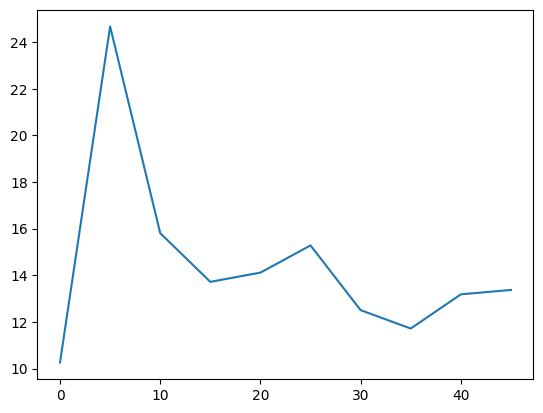

In [488]:
plt.plot(*zip(*hist_meds))

In [115]:
from math import prod

In [460]:
sum(prod(v.size()) for k, v in model.state_dict().items())

1585650

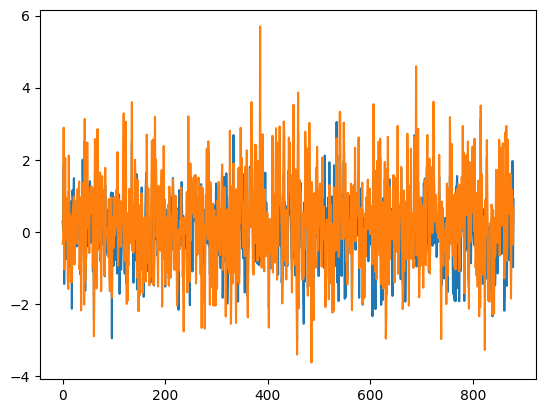

In [490]:
t = 19
plt.plot(es[t])
plt.plot(model(test_sigs[t].unsqueeze(0), torch.tensor([t])).detach().numpy())
# plt.plot(sqrt_alphas_cumprod[t] * xt_test + sqrt_one_minus_alphas_cumprod[t] * es[t])

# plt.plot(xt_test)
# plt.plot(
#     (
#         (test_sigs[t] 
#         - sqrt_one_minus_alphas_cumprod[t] * model(test_sigs[t].unsqueeze(0), torch.tensor([t])))
#         /sqrt_alphas_cumprod[t]
#     ).detach().numpy())
# len(test_sigs[0])

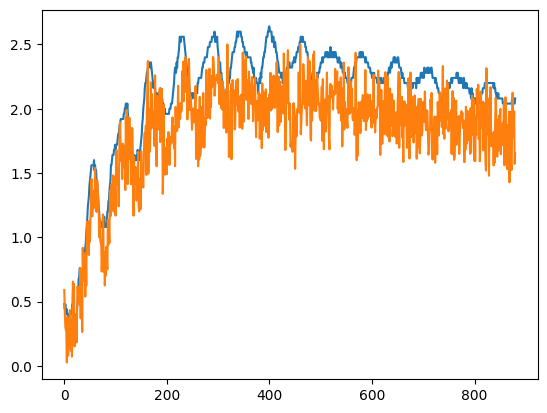

In [493]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = (1. - alphas) * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def p_sample(x):
    for t in reversed(range(T)):
        t = torch.tensor([t])
        model_mean = torch.sqrt(1.0 / alphas[t]) * (x - (1 - alphas[t]) * model(x, t) / sqrt_one_minus_alphas_cumprod[t])
        x = model_mean + (torch.sqrt(posterior_variance[t]) * torch.randn(1) if t > 0 else 0)
        
    return x

for k in [ks:=[*df_ser.keys()],random.shuffle(ks),ks][-1]:
    plt.plot(df_ser[k][120:].to_numpy())
    break
plt.plot(p_sample(torch.randn((880,)).unsqueeze(0)).detach().squeeze())

In [358]:
torch.cat((torch.randn(1000), t))

TypeError: expected Tensor as element 1 in argument 0, but got int

In [ ]:

(torch.sqrt(1.0 / alphas[t]) * (model(torch.randn(1000), t) - (1 - alphas[t]) * model(model(torch.randn(1000), t), t) / sqrt_one_minus_alphas_cumprod[t])).shape

torch.Size([1000])

In [ ]:
torch.randint(0, T, (1,)).shape

torch.Size([1])

In [ ]:
torch.tensor([5]).shape

torch.Size([1])

In [494]:
torch.save(model.state_dict(), "./model2.pth")

In [429]:
torch.tensor([1]).type(torch.float64)

tensor([1.])

In [435]:
xt_test.shape

torch.Size([880])

In [451]:
sqrt_alphas_cumprod[0]

tensor(0.9995, dtype=torch.float32)

In [482]:
statistics.median(deque([1.0, 2.0, -1.0]))

1.0

In [480]:
import statistics